<a href="https://colab.research.google.com/github/nicktien007/Nick.Colab/blob/main/DIP/5109056024_DIP_HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4: Use a CNN-based neural network to classify the scene is ​indoors or outdoors

訓練「CNN」模型進行影像二元分類，本次作業為對`室內`及`室外`進行分類

Dataset：

https://drive.google.com/file/d/1EmDy1ceebJKtQUZ0heZqy2y3iimxVXan/view?usp=sharing

## 訓練結果
Test Loss: 0.486845

Test Accuracy: 81% (65/80)

## Initialize

In [117]:
# 取得google drive存取權限
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#定義路徑
SYS_DIR = "/content/drive/MyDrive"

Mounted at /content/drive


In [118]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

In [119]:
!ls drive/MyDrive/

Dataset  Model	Other  QAbot


In [120]:
# number of subprocesses to use for data loading
num_workers = 0
# 每批次餵多少資料進Model
batch_size = 32
# learning rate
LR = 0.001
# 使用GPU
device = torch.device('cuda')

## Load & Show Images

In [121]:
#標準化
transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])

Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [122]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [123]:
PATH_train=SYS_DIR + "/Dataset/DIP/temp/train"
PATH_val=SYS_DIR + "/Dataset/DIP/temp/valid"
PATH_test=SYS_DIR + "/Dataset/DIP/temp/test"

TRAIN =Path(PATH_train)
VALID = Path(PATH_val)
TEST=Path(PATH_test)

In [124]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)

print(train_data.class_to_idx)
print(valid_data.class_to_idx)

{'indoor': 0, 'outdoor': 1}
{'indoor': 0, 'outdoor': 1}


In [125]:
# build data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [126]:
images,labels = next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['indoor','outdoor']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) # 將 3x224x224 轉為 224x224x3
  image = torch.clamp(image,0,1)
  return image

def show_imgs(img):
    img = denormalize(img) 
    plt.imshow(img)

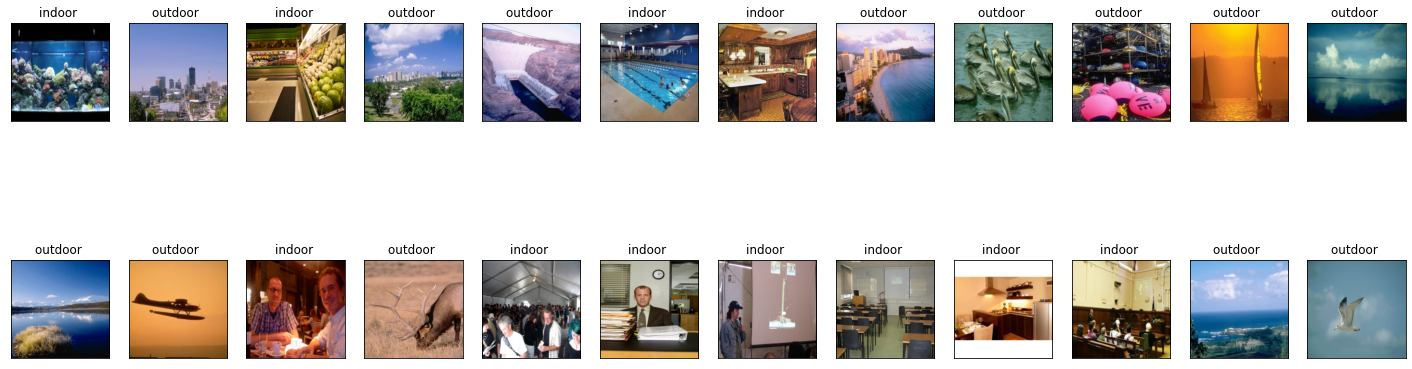

In [128]:
# iter training images
dataiter = iter(train_loader)

# 轉 numpy
images, labels = dataiter.next()

# 繪製圖片及標籤
figure = plt.figure(figsize=(25, 8))

for idx in np.arange(24):
    ax = figure.add_subplot(2, 24/2, idx+1, xticks=[], yticks=[])
    show_imgs(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

## Define CNN Model

In [129]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,220,220) #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU() # 採用ReLU 激勵函數

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,106,106)
        self.relu2 = nn.ReLU() 

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,53,53)        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,51,51)
        self.relu3 = nn.ReLU()

        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,25,25)
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0) #output_shape=(8,23,23)
        self.relu4 = nn.ReLU()

        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11)
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1

        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2

        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3

        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        out = self.output(out)

        return out

In [130]:
from torchsummary import summary

model = CNN_Model()
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Conv2d-7           [-1, 16, 51, 51]           4,624
              ReLU-8           [-1, 16, 51, 51]               0
         MaxPool2d-9           [-1, 16, 25, 25]               0
           Conv2d-10            [-1, 8, 23, 23]           1,160
             ReLU-11            [-1, 8, 23, 23]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                   

## Train & Validate Model

In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR) # 使用Adam優化器
epoch = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epoch + 1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    
    # enable train mode
    model.train()
    for data, target in tqdm(train_loader):        
        if device:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad() # 梯度歸零
        output = model(data)        
        loss = criterion(output, target) # 計算 loss
        loss.backward() # 反向傳播
        optimizer.step()
        train_loss += loss.item()*data.size(0) # 更新 loss
        
    # enable validate mode 
    model.eval()
    for data, target in tqdm(valid_loader):
        if device:
            data, target = data.cuda(), target.cuda()

        output = model(data)        
        loss = criterion(output, target)# 計算 loss
        valid_loss += loss.item()*data.size(0)# 更新 loss
    
    # 計算平均Loss   
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    print('Training Loss: {:.6f} Validation Loss: {:.6f}'.format(train_loss, valid_loss))
    
    # save model
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CNN.pth')
        valid_loss_min = valid_loss

running epoch: 1



Training Loss: 0.618033 Validation Loss: 0.499258
Validation loss decreased (inf --> 0.499258).  Saving model ...
running epoch: 2



Training Loss: 0.582503 Validation Loss: 0.561870
running epoch: 3



Training Loss: 0.549032 Validation Loss: 0.533551
running epoch: 4



Training Loss: 0.511113 Validation Loss: 0.500042
running epoch: 5



Training Loss: 0.494097 Validation Loss: 0.483019
Validation loss decreased (0.499258 --> 0.483019).  Saving model ...


## Test Model

In [132]:
def test(loaders, model, criterion):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders): 
        if device:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target) #計算 loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        # 轉成預測分類
        pred = output.data.max(1, keepdim=True)[1]
        # 與真實分類做比較
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [133]:
model.to(device)
test(test_loader, model, criterion)

Test Loss: 0.486845
Test Accuracy: 81% (65/80)
